Following the walkthrough at http://soft-matter.github.io/trackpy/dev/tutorial/walkthrough.html

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("figure", figsize=(10,5))
mpl.rc("image", cmap="gray")

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pandas as pd

import pims
import trackpy as tp

# Importing data

In [3]:
path = "../data/onion_2/Onion_bulk_20x/*.bmp"

frames = pims.as_gray(pims.open(path))
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/DanielBautista/Documents/Berkeley/Berkeley_Semester_5/Physics_111B/Lab_3/data/onion_2/Onion_bulk_20x/*.bmp
    Length: 358 frames
    Frame Shape: (200, 200, 3)
    Pixel Datatype: uint8

Frame([[ 93.6543,  92.5139,  93.2293, ..., 114.9331, 119.4474, 126.3677],
       [102.4145, 101.9116, 101.6953, ..., 123.9857, 129.2875, 136.9232],
       [ 92.7226,  92.2976,  93.3735, ..., 114.9331, 119.9465, 124.7206],
       ...,
       [114.2096, 115.9875, 117.7067, ...,  93.05  ,  92.7616,  93.2645],
       [107.9409, 109.2938, 111.1572, ...,  86.1534,  86.1534,  85.7284],
       [111.4145, 113.9078, 115.627 , ...,  93.5491,  93.477 ,  93.2645]])
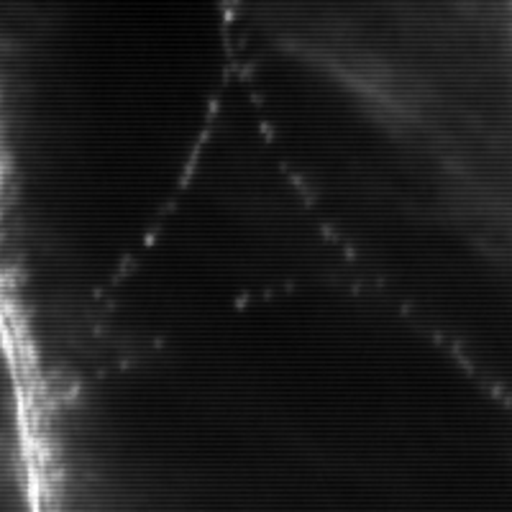

In [4]:
frames[0]

# Locating features

In [5]:
f = tp.locate(frames[0], diameter=11, minmass=140, maxsize=3)
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,5.633049,88.751746,723.030235,2.085141,0.094262,47.678487,9401.0151,0.469362,0
5,17.422819,112.715604,222.873556,2.868336,0.192225,7.478978,8678.4549,3.596441,0
9,27.366337,95.581408,339.919567,2.631263,0.157973,14.210059,8543.0954,-14.496477,0
16,41.297569,82.767708,538.486443,2.303831,0.193431,30.850786,8576.9648,56.015651,0
19,50.399851,103.578224,503.148270,2.511956,0.232861,24.119705,8483.1624,-4.491584,0


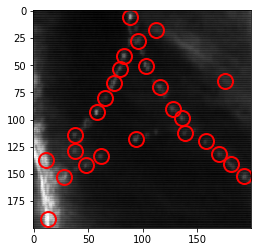

<AxesSubplot:>

In [6]:
tp.annotate(f, frames[0])

### Refining parameters to remove spurious features

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

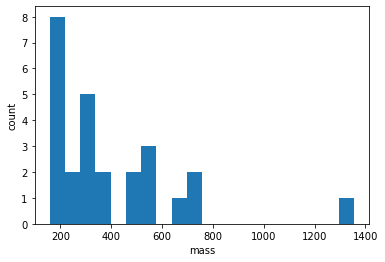

In [7]:
fig, ax = plt.subplots()
ax.hist(f["mass"], bins=20)

ax.set(xlabel="mass", ylabel="count")

In [8]:
# removing the high mass features
def mass_threshold(df, max_mass):
    df = df[df["mass"] < max_mass]
    return df

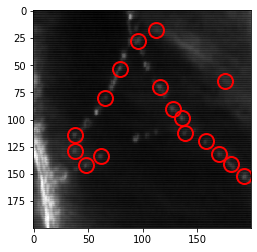

<AxesSubplot:>

In [9]:
f_new = mass_threshold(f, 400)
tp.annotate(f_new, frames[0])

### Check subpixel accuracy

The decimal part of x, y positions should be evenly distributed. If the mask size is too small, then the histogram will show a dip in the middle.

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

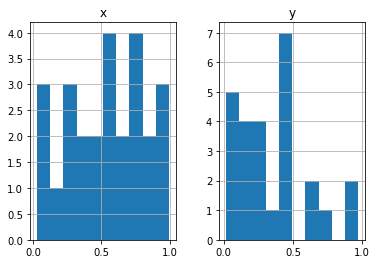

In [10]:
tp.subpx_bias(f)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

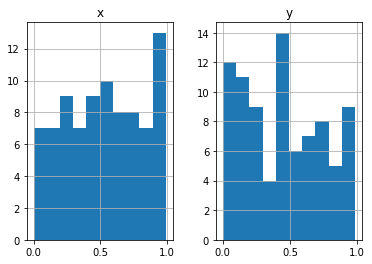

In [11]:
tp.subpx_bias(tp.locate(frames[0],11))

### Looking at several frames in a row

In [12]:
len(frames)

358

In [13]:
f = tp.batch(frames, diameter=9, minmass=132, maxsize=3)

Frame 357: 25 features


# Linking features into particle trajectories

In [14]:
t = tp.link(f, search_range=10, memory=3)
t.head()

Frame 357: 25 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,5.732875,88.765092,540.737228,1.836021,0.053995,43.130433,6126.9058,0.238771,0,0
28,185.119352,22.603581,198.399990,1.769063,0.159411,14.715089,8003.8252,0.080846,0,1
27,158.047079,7.898940,686.196727,2.422117,0.334792,33.320373,10250.5033,0.045122,0,2
26,152.168783,193.426438,226.477056,1.991955,0.076918,15.560784,5504.4689,0.677942,0,3
25,152.198118,28.536404,341.491543,2.226189,0.285273,20.634952,7043.6835,0.122188,0,4


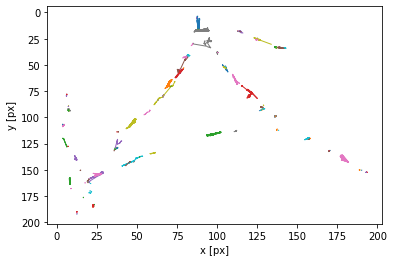

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [15]:
tp.plot_traj(t)

### Filtering spurious trajectories

We want to keep trajectories that persist for many frames and discard trajectories that only happen for a few frames. 

In [16]:
t1 = tp.filter_stubs(t, threshold=25)

print("Before:", t["particle"].nunique())
print("After: ",t1["particle"].nunique())

Before: 160
After:  57


We can also filter trajectories by their particle's appearance. We can look at a feature's "average appearance" throughout its trajectory.

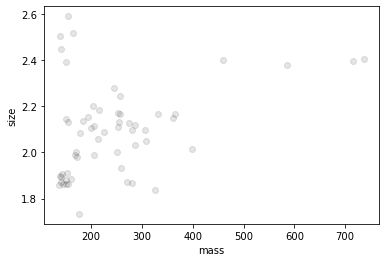

<AxesSubplot:xlabel='mass', ylabel='size'>

In [17]:
plt.figure()
tp.mass_size(t1.groupby("particle").mean())

### Removing overall drift

Compute the overall drifting motion, which will then be subtracted away, putting us in the reference frame of the particle's average position

In [18]:
d = tp.compute_drift(t1)

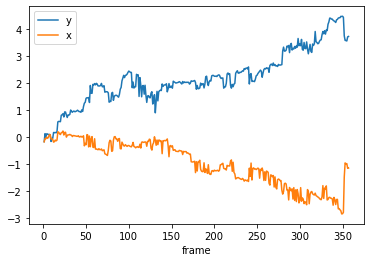

In [19]:
d.plot()
plt.show()

In [20]:
tm = tp.subtract_drift(t1.copy(), d)

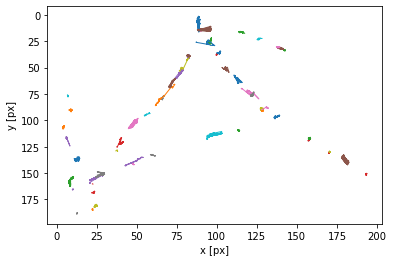

In [21]:
ax = tp.plot_traj(tm)
plt.show()

Obviously, for images containing particles with net movement in several directions, we will not have an overall bulk flow, and so, will not transform to the total comoving frame.

# Analyze trajectories

### Mean squared displacement of individual probes

In [22]:
im = tp.imsd(tm, 0.39625, 24)

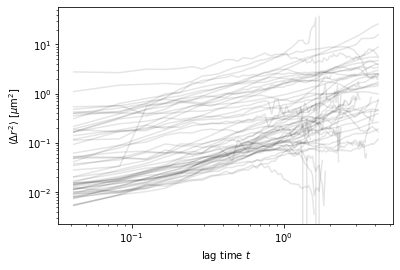

In [23]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

### Ensemble mean squared displacement

In [24]:
em = tp.emsd(tm, 0.39625, 24)

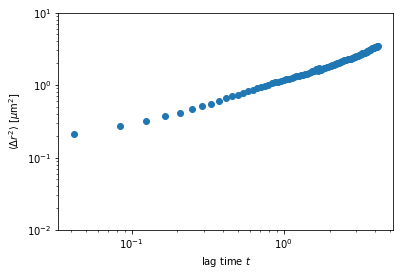

In [25]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

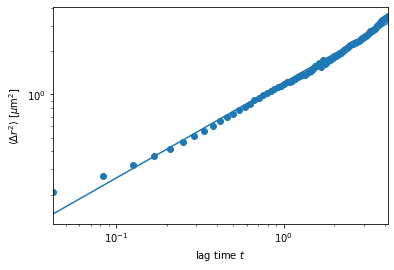

,n,A
msd,0.662877,1.206815


In [26]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
fits = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
fits

Calculating the dispersion coefficient from the fit results, where $$A = 4D$$

In [27]:
D = fits["A"][0]/4
D

0.3017036443952102